In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

df = pd.read_csv('HS_3650_Minute_All.csv')
df.describe()
df.info()

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import itertools



# Convert timestamp to datetime and handle timezone
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

# Aggregate to daily closes (last close per day per symbol)
df_daily = df.groupby([df['timestamp'].dt.date, 'symbol'])['close'].last().reset_index()
df_daily['timestamp'] = pd.to_datetime(df_daily['timestamp'])

# Pivot to get close prices by date and symbol
close_prices = df_daily.pivot_table(index='timestamp', columns='symbol', values='close')

# Handle missing data: drop columns with excessive NaNs (e.g., >50% missing)
threshold = len(close_prices) * 0.5
close_prices = close_prices.dropna(axis=1, thresh=threshold)
print(f"Tickers after filtering: {list(close_prices.columns)}")  # Verify tickers

# Compute daily returns
returns = close_prices.pct_change().dropna()
print(returns.head())  # Preview


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86482762 entries, 0 to 86482761
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   symbol       object 
 1   timestamp    object 
 2   open         float64
 3   high         float64
 4   low          float64
 5   close        float64
 6   volume       float64
 7   trade_count  float64
 8   vwap         float64
 9   ticker       object 
dtypes: float64(7), object(3)
memory usage: 6.4+ GB
Tickers after filtering: ['AAPL', 'ACN', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AMAT', 'AMD', 'ANET', 'APH', 'ASML', 'ASX', 'AVGO', 'BR', 'CDNS', 'CDW', 'CHKP', 'CPAY', 'CRM', 'CRWD', 'CSCO', 'CTSH', 'CYBR', 'DDOG', 'DELL', 'ERIC', 'FI', 'FICO', 'FIS', 'FTNT', 'GDDY', 'GIB', 'GLW', 'GRMN', 'HPE', 'HPQ', 'HUBS', 'IBM', 'INFY', 'INTC', 'INTU', 'IT', 'JBL', 'KEYS', 'KLAC', 'LDOS', 'LRCX', 'MCHP', 'MPWR', 'MRVL', 'MSFT', 'MSI', 'MSTR', 'MU', 'NET', 'NOK', 'NOW', 'NTAP', 'NVDA', 'NXPI', 'ON', 'ORCL', 'PANW', 'PAYX', 'PLTR', 'PTC

/var/folders/_j/71vsn5fs7rq5wmlb5w4_6xcc0000gn/T/ipykernel_30802/180964015.py:38: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()


In [37]:
# Features: mean return and volatility
features = pd.DataFrame({
    'mean_return': returns.mean(),
    'volatility': returns.std()
}, index=returns.columns)

# Add PCA components (5 dimensions)
pca = PCA(n_components=5)
pca_components = pca.fit_transform(returns.T)  # Transpose so stocks are rows
pca_df = pd.DataFrame(pca_components, index=returns.columns, columns=[f'pca_{i}' for i in range(5)])
features = pd.concat([features, pca_df], axis=1)

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features.dropna())
features = features.dropna()  # Align index
print(features.head())  # Preview

        mean_return  volatility     pca_0     pca_1     pca_2     pca_3  \
symbol                                                                    
AAPL       0.000657    0.017921 -0.106755  0.036822  0.023010 -0.022196   
ACN        0.000344    0.016113 -0.241028  0.101360  0.045499  0.033877   
ADBE       0.000011    0.021550 -0.013946  0.129451 -0.061580  0.007961   
ADI        0.000814    0.020242 -0.065637 -0.169731 -0.020442 -0.159056   
ADP        0.000817    0.014557 -0.321665  0.123271  0.069832  0.047719   

           pca_4  
symbol            
AAPL   -0.025097  
ACN    -0.044674  
ADBE   -0.104428  
ADI    -0.003646  
ADP     0.009426  


In [38]:
# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features.dropna())  # Drop NaNs if any
features = features.dropna()  # Align index
print(features.head())  # Preview

        mean_return  volatility     pca_0     pca_1     pca_2     pca_3  \
symbol                                                                    
AAPL       0.000657    0.017921 -0.106755  0.036822  0.023010 -0.022196   
ACN        0.000344    0.016113 -0.241028  0.101360  0.045499  0.033877   
ADBE       0.000011    0.021550 -0.013946  0.129451 -0.061580  0.007961   
ADI        0.000814    0.020242 -0.065637 -0.169731 -0.020442 -0.159056   
ADP        0.000817    0.014557 -0.321665  0.123271  0.069832  0.047719   

           pca_4  
symbol            
AAPL   -0.025097  
ACN    -0.044674  
ADBE   -0.104428  
ADI    -0.003646  
ADP     0.009426  


In [39]:

# Add PCA components (reduce returns to 5 dimensions for similarity in time-series behavior)
pca = PCA(n_components=5)
pca_components = pca.fit_transform(returns.T)  # Transpose so stocks are rows
pca_df = pd.DataFrame(pca_components, index=returns.columns, columns=[f'pca_{i}' for i in range(5)])
features = pd.concat([features, pca_df], axis=1)

In [40]:
# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features.dropna())  # Drop NaNs if any
features = features.dropna()  # Align index
print(features.head())  # Preview

        mean_return  volatility     pca_0     pca_1     pca_2     pca_3  \
symbol                                                                    
AAPL       0.000657    0.017921 -0.106755  0.036822  0.023010 -0.022196   
ACN        0.000344    0.016113 -0.241028  0.101360  0.045499  0.033877   
ADBE       0.000011    0.021550 -0.013946  0.129451 -0.061580  0.007961   
ADI        0.000814    0.020242 -0.065637 -0.169731 -0.020442 -0.159056   
ADP        0.000817    0.014557 -0.321665  0.123271  0.069832  0.047719   

           pca_4     pca_0     pca_1     pca_2     pca_3     pca_4  
symbol                                                              
AAPL   -0.025097 -0.106755  0.036822  0.023010 -0.022194 -0.025091  
ACN    -0.044674 -0.241028  0.101360  0.045499  0.033877 -0.044605  
ADBE   -0.104428 -0.013946  0.129451 -0.061581  0.007958 -0.104501  
ADI    -0.003646 -0.065637 -0.169731 -0.020442 -0.159055 -0.003620  
ADP     0.009426 -0.321665  0.123271  0.069831  0.047712  0.

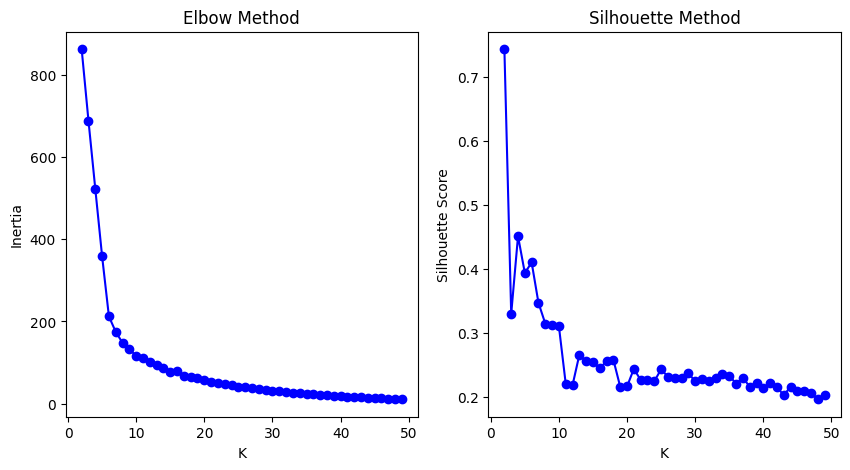

kmeans_cluster
0    48
1    16
2     1
3     1
4    26
dtype: int64
        mean_return  volatility  kmeans_cluster
symbol                                         
AAPL       0.000657    0.017921               0
ACN        0.000344    0.016113               0
ADBE       0.000011    0.021550               0
ADI        0.000814    0.020242               4
ADP        0.000817    0.014557               0
...             ...         ...             ...
WDC        0.000937    0.029029               4
WIT        0.000344    0.019292               0
XYZ        0.000161    0.038983               1
ZM        -0.001035    0.029499               1
ZS         0.001123    0.033063               1

[92 rows x 3 columns]


In [41]:
# Elbow method for optimal K
inertias = []
sil_scores = []
k_range = range(2, 50)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(features_scaled, kmeans.labels_))

# Plot elbow and silhouette
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.subplot(1, 2, 2)
plt.plot(k_range, sil_scores, 'bo-')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

# Apply K-Means (choose K from plot, e.g., 5)
optimal_k = 5  # Update based on elbow/silhouette
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
features['kmeans_cluster'] = kmeans.fit_predict(features_scaled)
print(features.groupby('kmeans_cluster').size())  # Cluster sizes
print(features[['mean_return', 'volatility', 'kmeans_cluster']])  # View results

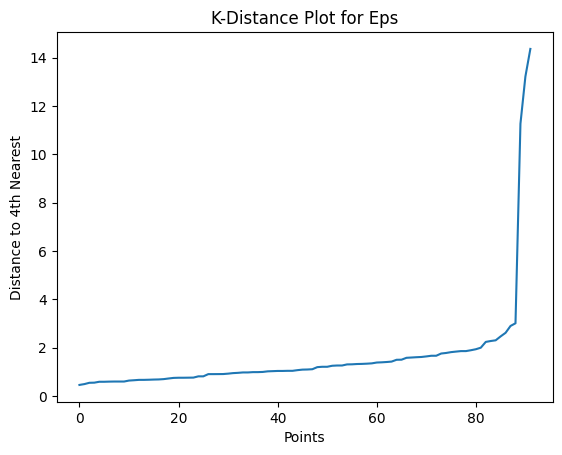

dbscan_cluster
-1    15
 0    72
 1     5
dtype: int64
        mean_return  volatility  dbscan_cluster
symbol                                         
AAPL       0.000657    0.017921               0
ACN        0.000344    0.016113               0
ADBE       0.000011    0.021550               0
ADI        0.000814    0.020242               0
ADP        0.000817    0.014557               0
...             ...         ...             ...
WDC        0.000937    0.029029              -1
WIT        0.000344    0.019292               0
XYZ        0.000161    0.038983              -1
ZM        -0.001035    0.029499              -1
ZS         0.001123    0.033063               1

[92 rows x 3 columns]


In [42]:
from sklearn.neighbors import NearestNeighbors

# K-distance plot for eps
neighbors = NearestNeighbors(n_neighbors=5)
distances = neighbors.fit(features_scaled).kneighbors(features_scaled)[0]
distances = np.sort(distances[:, 4], axis=0)
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('Distance to 4th Nearest')
plt.title('K-Distance Plot for Eps')
plt.show()  # Choose eps at "knee" (e.g., 1.0-2.0)

# Apply DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)  # Tune eps
features['dbscan_cluster'] = dbscan.fit_predict(features_scaled)
print(features.groupby('dbscan_cluster').size())  # -1 = noise
print(features[['mean_return', 'volatility', 'dbscan_cluster']])  # View results

In [43]:
# List K-Means clusters
print("K-Means Clusters:")
for cluster_id in sorted(features['kmeans_cluster'].unique()):
    cluster_stocks = features[features['kmeans_cluster'] == cluster_id].index.tolist()
    print(f"Cluster {cluster_id} ({len(cluster_stocks)} stocks):")
    print(cluster_stocks)
    print()  # Blank line for readability

K-Means Clusters:
Cluster 0 (48 stocks):
['AAPL', 'ACN', 'ADBE', 'ADP', 'ADSK', 'APH', 'BR', 'CDW', 'CHKP', 'CPAY', 'CRM', 'CSCO', 'CTSH', 'ERIC', 'FI', 'FICO', 'FIS', 'GDDY', 'GIB', 'GLW', 'GRMN', 'HPE', 'HPQ', 'IBM', 'INFY', 'INTU', 'IT', 'KEYS', 'LDOS', 'MSFT', 'MSI', 'NOK', 'NTAP', 'ORCL', 'PAYX', 'PTC', 'ROP', 'SAP', 'SONY', 'SSNC', 'STX', 'TDY', 'TEL', 'TYL', 'UI', 'VRSN', 'WDAY', 'WIT']

Cluster 1 (16 stocks):
['CRWD', 'CYBR', 'DDOG', 'FTNT', 'HUBS', 'NET', 'NOW', 'PANW', 'PLTR', 'SHOP', 'SNOW', 'TEAM', 'UBER', 'XYZ', 'ZM', 'ZS']

Cluster 2 (1 stocks):
['MSTR']

Cluster 3 (1 stocks):
['SMCI']

Cluster 4 (26 stocks):
['ADI', 'AMAT', 'AMD', 'ANET', 'ASML', 'ASX', 'AVGO', 'CDNS', 'DELL', 'INTC', 'JBL', 'KLAC', 'LRCX', 'MCHP', 'MPWR', 'MRVL', 'MU', 'NVDA', 'NXPI', 'ON', 'QCOM', 'SNPS', 'STM', 'TSM', 'TXN', 'WDC']



In [44]:
# List DBSCAN clusters
print("DBSCAN Clusters:")
for cluster_id in sorted(features['dbscan_cluster'].unique()):
    cluster_stocks = features[features['dbscan_cluster'] == cluster_id].index.tolist()
    if cluster_id == -1:
        print(f"Noise (-1) ({len(cluster_stocks)} stocks):")
    else:
        print(f"Cluster {cluster_id} ({len(cluster_stocks)} stocks):")
    print(cluster_stocks)
    print()  # Blank line for readability

DBSCAN Clusters:
Noise (-1) (15 stocks):
['ANET', 'DELL', 'MSTR', 'NET', 'NOK', 'NVDA', 'PLTR', 'SHOP', 'SMCI', 'SNOW', 'UBER', 'UI', 'WDC', 'XYZ', 'ZM']

Cluster 0 (72 stocks):
['AAPL', 'ACN', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AMAT', 'AMD', 'APH', 'ASML', 'ASX', 'AVGO', 'BR', 'CDNS', 'CDW', 'CHKP', 'CPAY', 'CRM', 'CSCO', 'CTSH', 'CYBR', 'ERIC', 'FI', 'FICO', 'FIS', 'FTNT', 'GDDY', 'GIB', 'GLW', 'GRMN', 'HPE', 'HPQ', 'IBM', 'INFY', 'INTC', 'INTU', 'IT', 'JBL', 'KEYS', 'KLAC', 'LDOS', 'LRCX', 'MCHP', 'MPWR', 'MRVL', 'MSFT', 'MSI', 'MU', 'NOW', 'NTAP', 'NXPI', 'ON', 'ORCL', 'PANW', 'PAYX', 'PTC', 'QCOM', 'ROP', 'SAP', 'SNPS', 'SONY', 'SSNC', 'STM', 'STX', 'TDY', 'TEL', 'TSM', 'TXN', 'TYL', 'VRSN', 'WDAY', 'WIT']

Cluster 1 (5 stocks):
['CRWD', 'DDOG', 'HUBS', 'TEAM', 'ZS']



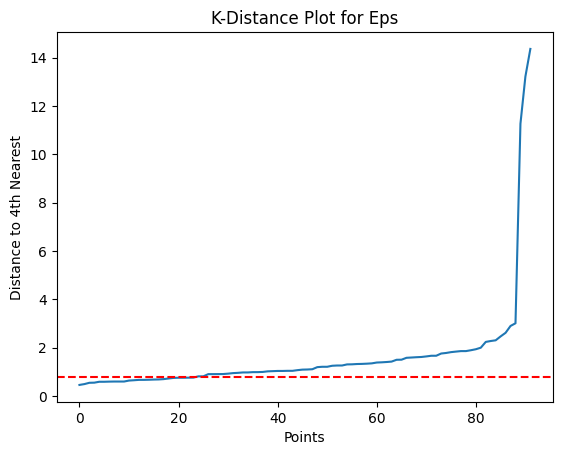

DBSCAN Clusters (eps=0.8, min_samples=3):
Noise (-1) (46 stocks):
['ADI', 'AMD', 'ANET', 'ASML', 'ASX', 'AVGO', 'CDNS', 'CRWD', 'CYBR', 'DDOG', 'DELL', 'ERIC', 'FICO', 'FIS', 'FTNT', 'HPE', 'HUBS', 'INTC', 'JBL', 'LDOS', 'MPWR', 'MRVL', 'MSTR', 'MU', 'NET', 'NOK', 'NOW', 'NVDA', 'ON', 'ORCL', 'PANW', 'PLTR', 'QCOM', 'SHOP', 'SMCI', 'SNOW', 'SNPS', 'TEAM', 'TSM', 'TXN', 'UBER', 'UI', 'WDC', 'XYZ', 'ZM', 'ZS']

Cluster 0 (40 stocks):
['AAPL', 'ACN', 'ADBE', 'ADP', 'ADSK', 'APH', 'BR', 'CDW', 'CHKP', 'CPAY', 'CRM', 'CSCO', 'CTSH', 'FI', 'GDDY', 'GIB', 'GLW', 'GRMN', 'HPQ', 'IBM', 'INFY', 'INTU', 'IT', 'KEYS', 'MSFT', 'MSI', 'NTAP', 'PAYX', 'PTC', 'ROP', 'SAP', 'SONY', 'SSNC', 'STX', 'TDY', 'TEL', 'TYL', 'VRSN', 'WDAY', 'WIT']

Cluster 1 (3 stocks):
['AMAT', 'KLAC', 'LRCX']

Cluster 2 (3 stocks):
['MCHP', 'NXPI', 'STM']



In [45]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# K-distance plot for finer eps
neighbors = NearestNeighbors(n_neighbors=5)  # Match min_samples
distances = neighbors.fit(features_scaled).kneighbors(features_scaled)[0]
distances = np.sort(distances[:, 4], axis=0)
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('Distance to 4th Nearest')
plt.title('K-Distance Plot for Eps')
plt.axhline(y=0.8, color='r', linestyle='--')  # Example eps
plt.show()  # Choose smaller eps at "knee" (e.g., 0.5-1.0)

# Apply DBSCAN with smaller eps
dbscan = DBSCAN(eps=0.8, min_samples=3)  # Lower eps, reduced min_samples
features['dbscan_cluster'] = dbscan.fit_predict(features_scaled)

# List new DBSCAN clusters
print("DBSCAN Clusters (eps=0.8, min_samples=3):")
for cluster_id in sorted(features['dbscan_cluster'].unique()):
    cluster_stocks = features[features['dbscan_cluster'] == cluster_id].index.tolist()
    if cluster_id == -1:
        print(f"Noise (-1) ({len(cluster_stocks)} stocks):")
    else:
        print(f"Cluster {cluster_id} ({len(cluster_stocks)} stocks):")
    print(cluster_stocks)
    print()

In [46]:
# Adjust feature weights (e.g., double volatility and PCA weights)
features_weighted = features.copy()
features_weighted['volatility'] *= 2  # Emphasize volatility
features_weighted[[f'pca_{i}' for i in range(5)]] *= 2  # Emphasize PCA
features_weighted_scaled = StandardScaler().fit_transform(features_weighted)

# Re-run K-Means with weighted features
kmeans = KMeans(n_clusters=15, random_state=42, n_init=10)
features['kmeans_cluster_weighted'] = kmeans.fit_predict(features_weighted_scaled)

# List weighted K-Means clusters
print("K-Means Clusters (Weighted Features, K=15):")
for cluster_id in sorted(features['kmeans_cluster_weighted'].unique()):
    cluster_stocks = features[features['kmeans_cluster_weighted'] == cluster_id].index.tolist()
    print(f"Cluster {cluster_id} ({len(cluster_stocks)} stocks):")
    print(cluster_stocks)
    print()

K-Means Clusters (Weighted Features, K=15):
Cluster 0 (11 stocks):
['ADI', 'ASML', 'ASX', 'AVGO', 'DELL', 'INTC', 'JBL', 'QCOM', 'TSM', 'TXN', 'WDC']

Cluster 1 (7 stocks):
['ERIC', 'FICO', 'FIS', 'LDOS', 'NOK', 'ORCL', 'UI']

Cluster 2 (9 stocks):
['CRWD', 'DDOG', 'HUBS', 'SHOP', 'SNOW', 'TEAM', 'XYZ', 'ZM', 'ZS']

Cluster 3 (1 stocks):
['MSTR']

Cluster 4 (3 stocks):
['AMAT', 'KLAC', 'LRCX']

Cluster 5 (1 stocks):
['SMCI']

Cluster 6 (9 stocks):
['APH', 'CDW', 'GLW', 'HPE', 'HPQ', 'KEYS', 'NTAP', 'STX', 'TEL']

Cluster 7 (6 stocks):
['AMD', 'MPWR', 'MRVL', 'MU', 'NVDA', 'ON']

Cluster 8 (5 stocks):
['CYBR', 'FTNT', 'NOW', 'PANW', 'UBER']

Cluster 9 (22 stocks):
['ACN', 'ADP', 'BR', 'CHKP', 'CPAY', 'CSCO', 'CTSH', 'FI', 'GIB', 'GRMN', 'IBM', 'INFY', 'IT', 'MSI', 'PAYX', 'ROP', 'SAP', 'SONY', 'SSNC', 'TDY', 'VRSN', 'WIT']

Cluster 10 (1 stocks):
['PLTR']

Cluster 11 (3 stocks):
['MCHP', 'NXPI', 'STM']

Cluster 12 (10 stocks):
['AAPL', 'ADBE', 'ADSK', 'CRM', 'GDDY', 'INTU', 'MSFT', 'PTC

In [47]:
# Recompute features with fewer PCA components
pca = PCA(n_components=2)  # Reduce to 2 dimensions
pca_components = pca.fit_transform(returns.T)
pca_df = pd.DataFrame(pca_components, index=returns.columns, columns=['pca_0', 'pca_1'])
features_reduced = pd.DataFrame({
    'mean_return': returns.mean(),
    'volatility': returns.std()
}, index=returns.columns)
features_reduced = pd.concat([features_reduced, pca_df], axis=1)

# Normalize
features_reduced_scaled = StandardScaler().fit_transform(features_reduced.dropna())
features_reduced = features_reduced.dropna()

# Re-run K-Means
kmeans = KMeans(n_clusters=15, random_state=42, n_init=10)
features_reduced['kmeans_cluster'] = kmeans.fit_predict(features_reduced_scaled)

# List reduced K-Means clusters
print("K-Means Clusters (2 PCA Components, K=15):")
for cluster_id in sorted(features_reduced['kmeans_cluster'].unique()):
    cluster_stocks = features_reduced[features_reduced['kmeans_cluster'] == cluster_id].index.tolist()
    print(f"Cluster {cluster_id} ({len(cluster_stocks)} stocks):")
    print(cluster_stocks)
    print()

K-Means Clusters (2 PCA Components, K=15):
Cluster 0 (5 stocks):
['ADBE', 'ADSK', 'CRM', 'TYL', 'WDAY']

Cluster 1 (4 stocks):
['AMD', 'MPWR', 'MRVL', 'NVDA']

Cluster 2 (8 stocks):
['CRWD', 'DDOG', 'HUBS', 'SHOP', 'SNOW', 'TEAM', 'XYZ', 'ZS']

Cluster 3 (23 stocks):
['AAPL', 'ACN', 'ADP', 'BR', 'CDW', 'CHKP', 'CSCO', 'CTSH', 'FI', 'GIB', 'GRMN', 'IBM', 'INFY', 'IT', 'LDOS', 'MSFT', 'MSI', 'PAYX', 'ROP', 'SAP', 'SSNC', 'TDY', 'VRSN']

Cluster 4 (1 stocks):
['SMCI']

Cluster 5 (7 stocks):
['ANET', 'ASX', 'AVGO', 'DELL', 'JBL', 'STX', 'TSM']

Cluster 6 (1 stocks):
['MSTR']

Cluster 7 (8 stocks):
['CDNS', 'FICO', 'GDDY', 'INTU', 'ORCL', 'PTC', 'SNPS', 'UI']

Cluster 8 (2 stocks):
['NET', 'PLTR']

Cluster 9 (6 stocks):
['ASML', 'INTC', 'MCHP', 'NXPI', 'QCOM', 'STM']

Cluster 10 (6 stocks):
['AMAT', 'KLAC', 'LRCX', 'MU', 'ON', 'WDC']

Cluster 11 (5 stocks):
['CYBR', 'FTNT', 'NOW', 'PANW', 'UBER']

Cluster 12 (6 stocks):
['CPAY', 'ERIC', 'FIS', 'NOK', 'SONY', 'WIT']

Cluster 13 (9 stocks):
[

K-Means Cluster Sizes:
kmeans_cluster
0    48
1    16
2     1
3     1
4    26
Name: count, dtype: int64

DBSCAN Cluster Sizes:
dbscan_cluster
-1    46
 0    40
 1     3
 2     3
Name: count, dtype: int64


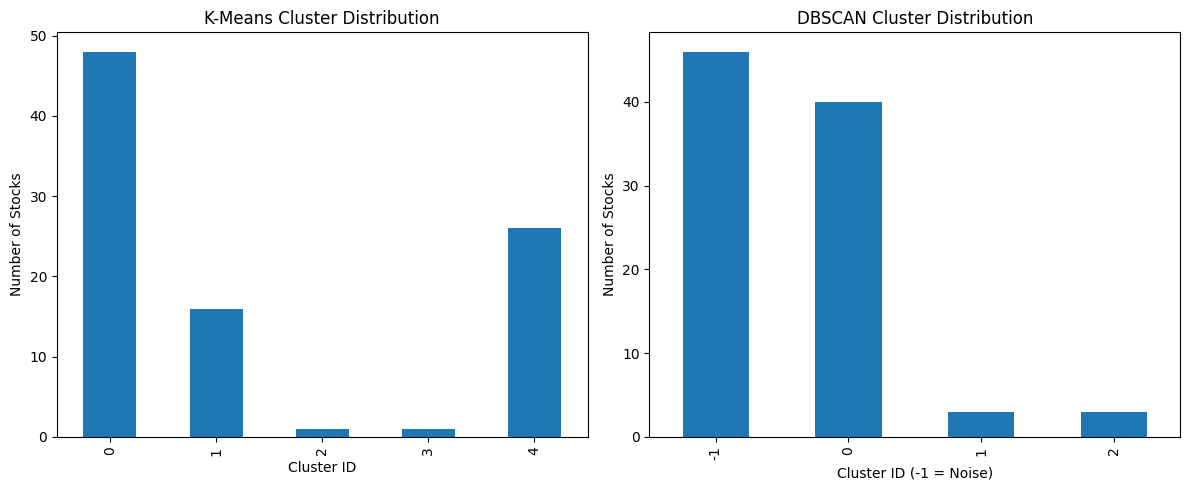

In [48]:
# K-Means size distribution
print("K-Means Cluster Sizes:")
print(features['kmeans_cluster'].value_counts().sort_index())

# DBSCAN size distribution
print("\nDBSCAN Cluster Sizes:")
print(features['dbscan_cluster'].value_counts().sort_index())

# Plot distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
features['kmeans_cluster'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Stocks')
plt.title('K-Means Cluster Distribution')
plt.subplot(1, 2, 2)
features['dbscan_cluster'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Cluster ID (-1 = Noise)')
plt.ylabel('Number of Stocks')
plt.title('DBSCAN Cluster Distribution')
plt.tight_layout()
plt.show()

In [49]:
from statsmodels.tsa.stattools import coint
import itertools

# Use new K-Means clusters
potential_pairs = []
for cluster_id in features['kmeans_cluster'].unique():
    cluster_stocks = features[features['kmeans_cluster'] == cluster_id].index.tolist()
    if len(cluster_stocks) < 2:
        continue
    for stock1, stock2 in itertools.combinations(cluster_stocks, 2):
        if stock1 in returns.columns and stock2 in returns.columns:
            try:
                score, pvalue, _ = coint(returns[stock1], returns[stock2])
                if pvalue < 0.05:
                    potential_pairs.append((stock1, stock2, pvalue))
            except:
                continue

# Sort and display pairs
pairs_df = pd.DataFrame(potential_pairs, columns=['Stock1', 'Stock2', 'P-Value'])
pairs_df = pairs_df.sort_values('P-Value')
print("Cointegrated Pairs:")
print(pairs_df)

Cointegrated Pairs:
     Stock1 Stock2       P-Value
0      AAPL    ACN  0.000000e+00
1012   NTAP    SAP  0.000000e+00
1011   NTAP    ROP  0.000000e+00
1010   NTAP    PTC  0.000000e+00
1009   NTAP   PAYX  0.000000e+00
...     ...    ...           ...
580      FI   LDOS  4.191144e-09
596      FI     UI  1.243198e-08
577      FI   INTU  1.468203e-08
597      FI   VRSN  1.648618e-08
754    GRMN   INTU  4.432251e-08

[1573 rows x 3 columns]


In [50]:
import pandas as pd
import numpy as np

# Assuming pairs_df is your cointegrated pairs DataFrame
# Example: pairs_df = pd.DataFrame({'Stock1': ['ADP', ...], 'Stock2': ['GDDY', ...], 'P-Value': [0.0, ...]})

# Compute correlations for cointegrated pairs
correlation_threshold = 0.7  # Adjust as needed
pairs_df['Correlation'] = pairs_df.apply(
    lambda row: returns[row['Stock1']].corr(returns[row['Stock2']]) if row['Stock1'] in returns.columns and row['Stock2'] in returns.columns else np.nan,
    axis=1
)

# Filter pairs with high correlation
high_corr_pairs = pairs_df[pairs_df['Correlation'] > correlation_threshold].copy()
print("Cointegrated Pairs with Correlation > {}:".format(correlation_threshold))
print(high_corr_pairs[['Stock1', 'Stock2', 'P-Value', 'Correlation']])

Cointegrated Pairs with Correlation > 0.7:
     Stock1 Stock2       P-Value  Correlation
1128    ADI   AMAT  0.000000e+00     0.716551
1138    ADI   KLAC  0.000000e+00     0.739937
1140    ADI   MCHP  0.000000e+00     0.818401
1425   NXPI     ON  0.000000e+00     0.797022
1430   NXPI    TXN  0.000000e+00     0.746386
1367   LRCX   NXPI  0.000000e+00     0.736755
1365   LRCX     MU  0.000000e+00     0.718151
1362   LRCX   MCHP  0.000000e+00     0.713178
1360   KLAC    TXN  0.000000e+00     0.704628
1354   KLAC   NXPI  0.000000e+00     0.740499
1372   LRCX    TSM  0.000000e+00     0.708008
1373   LRCX    TXN  0.000000e+00     0.704001
1390   MPWR   NXPI  0.000000e+00     0.703468
1383   MCHP    STM  0.000000e+00     0.714344
1379   MCHP   NXPI  0.000000e+00     0.803106
1350   KLAC   MPWR  0.000000e+00     0.740117
1467   CRWD     ZS  0.000000e+00     0.716919
1139    ADI   LRCX  0.000000e+00     0.726032
1349   KLAC   MCHP  0.000000e+00     0.729876
1191    AMD   NVDA  0.000000e+00     

In [51]:
# Get unique stocks from high-correlation, cointegrated pairs
high_corr_stocks = sorted(set(high_corr_pairs['Stock1']).union(set(high_corr_pairs['Stock2'])))
print("\nUnique Stocks with High Correlation and Cointegration:")
print(high_corr_stocks)
print(f"Total number of stocks: {len(high_corr_stocks)}")


Unique Stocks with High Correlation and Cointegration:
['ADI', 'ADP', 'AMAT', 'AMD', 'ASML', 'CDNS', 'CRWD', 'KLAC', 'LRCX', 'MCHP', 'MPWR', 'MU', 'NVDA', 'NXPI', 'ON', 'PAYX', 'SNPS', 'STM', 'TSM', 'TXN', 'ZS']
Total number of stocks: 21


In [52]:
# Assuming features DataFrame has kmeans_cluster and dbscan_cluster
# Filter features for high-correlation stocks
high_corr_features = features.loc[features.index.intersection(high_corr_stocks)]

# List stocks by K-Means cluster
print("\nK-Means Cluster Assignments for High-Correlation Stocks:")
for cluster_id in sorted(high_corr_features['kmeans_cluster'].unique()):
    cluster_stocks = high_corr_features[high_corr_features['kmeans_cluster'] == cluster_id].index.tolist()
    print(f"Cluster {cluster_id} ({len(cluster_stocks)} stocks):")
    print(cluster_stocks)
    print()

# List stocks by DBSCAN cluster
print("\nDBSCAN Cluster Assignments for High-Correlation Stocks:")
for cluster_id in sorted(high_corr_features['dbscan_cluster'].unique()):
    cluster_stocks = high_corr_features[high_corr_features['dbscan_cluster'] == cluster_id].index.tolist()
    if cluster_id == -1:
        print(f"Noise (-1) ({len(cluster_stocks)} stocks):")
    else:
        print(f"Cluster {cluster_id} ({len(cluster_stocks)} stocks):")
    print(cluster_stocks)
    print()


K-Means Cluster Assignments for High-Correlation Stocks:
Cluster 0 (2 stocks):
['ADP', 'PAYX']

Cluster 1 (2 stocks):
['CRWD', 'ZS']

Cluster 4 (17 stocks):
['ADI', 'AMAT', 'AMD', 'ASML', 'CDNS', 'KLAC', 'LRCX', 'MCHP', 'MPWR', 'MU', 'NVDA', 'NXPI', 'ON', 'SNPS', 'STM', 'TSM', 'TXN']


DBSCAN Cluster Assignments for High-Correlation Stocks:
Noise (-1) (13 stocks):
['ADI', 'AMD', 'ASML', 'CDNS', 'CRWD', 'MPWR', 'MU', 'NVDA', 'ON', 'SNPS', 'TSM', 'TXN', 'ZS']

Cluster 0 (2 stocks):
['ADP', 'PAYX']

Cluster 1 (3 stocks):
['AMAT', 'KLAC', 'LRCX']

Cluster 2 (3 stocks):
['MCHP', 'NXPI', 'STM']



In [54]:
# Save high-correlation pairs
high_corr_pairs.to_csv('high_corr_cointegrated_pairs.csv', index=False)
print("High-correlation pairs saved to 'high_corr_cointegrated_pairs.csv'")

# Save unique stocks
pd.DataFrame(high_corr_stocks, columns=['Stock']).to_csv('high_corr_stocks.csv', index=False)
print("Unique stocks saved to 'high_corr_LARGE_stocks.csv'")

High-correlation pairs saved to 'high_corr_cointegrated_pairs.csv'
Unique stocks saved to 'high_corr_LARGE_stocks.csv'
